<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/5_BurgersEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries in 218 Euclid choose Python 3.10.9 environment

In [32]:
from   pyDOE import *           # use for engineers to construct experimental design
from   pyDOE import lhs         # Latin Hypercube Sampling
import warnings
warnings.filterwarnings('ignore')
from   pathlib import Path           # this module is used to manipulate the python path and file path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   mpl_toolkits.axes_grid1 import make_axes_locatable
from   mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io
import torch
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import glob
import os
import re
import pandas as pd
from IPython.core.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
torch.set_default_dtype(torch.float) # Set default dtype to float32
torch.manual_seed(1234)              # PyTorch random number generator
np.random.seed(1234)                 # Random number generators in other libraries
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Device configuration
import random
print(device)
if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [33]:
def plot3D(x,t,y):
  x_plot = x.squeeze(1) 
  t_plot = t.squeeze(1)
  X,T    = torch.meshgrid(x_plot,t_plot)
  F_xt   = y
  fig,ax = plt.subplots(1,1)
  cp     = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [34]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [35]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    fig, ax = plt.subplots()
    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[int(t.shape[0]/3)-1]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[int(t.shape[0]/3*2)-1]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[int(t.shape[0]/3*3)-1]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    int(t.shape[0]/3*3)-1
    '''
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.00001, right=0.00015, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[int(t.shape[0]/3)-1,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(t.shape[0]/3)-1,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('{} seconds'.format(t[int(t.shape[0]/3)-1][0]), fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax = plt.subplot(gs1[0, 1])
    
    ax.plot(x,usol.T[int(t.shape[0]/3*2)-1,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(t.shape[0]/3*2)-1,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('{} seconds'.format(t[int(t.shape[0]/3*2)-1][0]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[int(t.shape[0]/3*3)-1,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(t.shape[0]/3*3)-1,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('{} seconds'.format(t[int(t.shape[0]/3*3)-1][0]), fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

### Neural Network

In [36]:
class FCN(nn.Module):          # nn.module => inherit module from torch  
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh() # define

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0  #
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) # fill the tensor with initial weight values    
            nn.init.zeros_(self.linears[i].bias.data) # set biases to zero
            
    'foward pass'
    def forward(self,x):     # feed the distance in, return value is the distance of x, ve   
        if torch.is_tensor(x) != True:    # when x is not empty     
            x = torch.from_numpy(x)       # convert numpy array to tensor array         
        u_b = torch.from_numpy(ub).float().to(device)  # ub => maximum value of x(1) and t(0.9)
        l_b = torch.from_numpy(lb).float().to(device)  # lb => minimum value of x(-1) and t(0)
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        #convert to float
        a = x.float()
        for i in range(len(layers)-2): # load the tensor into each layers, except last layer 
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)  # initiate last output layer input should be 256 x 20
        return a # the return value is an activated value of input value
    
    def loss_BC(self,x,y): 
        loss_u = self.loss_function(self.forward(x), y)                                                         
        return loss_u        # assuem y = torch.from_numpy(usol) => 256 x 100
                             # forward(x) is a => 256 x 2  => how to compute MSE of these two??
                             # why we need to calculate loss of boundary condition
    def loss_PDE(self, X_train_Nf):
        g = X_train_Nf.clone()  # X_train_Nf 100100 x 2 => collocation points 10000 x 2 from 100x2 (X_test)
        g.requires_grad = True # if it is true, gradients derivatives need to be computed. we need this
                               # as we need to train the weight through back propagation
        u = self.forward(g)    #
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        # the output of torch.autograd.grad is related to derivatives but it's not actually dy/dx, In fact autograd.grad returns the sum of the dydx over output dimension.
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nf.shape).to(device), create_graph=True)[0]                                  
        u_x = u_x_t[:,[0]]
        u_t = u_x_t[:,[1]]
        u_xx = u_xx_tt[:,[0]]
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        loss_f = self.loss_function(f,f_hat)
        return loss_f  
    def loss(self,x,y,X_train_Nf):
        loss_u = self.loss_BC(x,y) #MSE loss
        loss_f = self.loss_PDE(X_train_Nf)
        loss_val = loss_u + loss_f
        return loss_val
    'callable for optimizer'                                       
    def closure(self): # excute first actual training starts here
        optimizer.zero_grad()
        loss = self.loss(X_train_Nu, U_train_Nu, X_train_Nf)
        loss.backward() # to compute gradient, this is mandatory step
        # https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step
        self.iter += 1
        if self.iter % 100 == 0:
            error_vec, _ = PINN.test()
            print(loss,error_vec)                #
        return loss        
    'test neural network'
    def test(self):
        u_pred = self.forward(X_test)                                             # the reason use forward function because the weights are updated every time, and want to compute loss
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        #error_vec = torch.linalg.norm((u-u_pred),2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()
        #u_pred = np.reshape(u_pred,(256,100),order='F')
        u_pred = np.reshape(u_pred,(x.shape[0],t.shape[0]),order='F')
        return error_vec, u_pred



## Training Data

In [43]:
vel_final = np.empty((3000,0))
X_final = []
time_steps = sorted(list(set(["".join(re.findall(r'0.[0-9]*',item)) for item in glob.glob('./data/v9_m5_325/*')])))
for time_step in time_steps:
    hor5 = pd.read_csv('./data/v9_m5_325/hor5_vel_' + str(time_step) + '_sec_v325.csv',skiprows=4)
    hor6 = pd.read_csv('./data/v9_m5_325/hor6_vel_' + str(time_step) + '_sec_v325.csv',skiprows=4)
    hor8 = pd.read_csv('./data/v9_m5_325/hor8_vel_' + str(time_step) + '_sec_v325.csv',skiprows=4)
    hor  = pd.concat([hor5,hor6,hor8])
    vel_final = np.hstack((vel_final,hor['Velocity [ m s^-1 ]'].values.reshape(3000,1)))
time_steps = np.array([float(time_step) for time_step in time_steps]).reshape(15,1)
X_final = hor['Y [ m ]'].values.reshape(3000,1)

input is previous time steps, and output is next step

In [44]:
x    = X_final.astype(float)
t    = np.array(time_steps).reshape(-1,1).astype(float)
usol = vel_final.astype(float)

In [45]:
X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
# plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) #f_real was defined previously(function)
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None])).astype(float) # it becomes 2D array with first column is x-axis location
                                                               # and y-axis is time,
                                                               # there is no y-axis has been computed
steps=100000
lr=1e-3
lr=1e-4
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
# Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
# N_u = 100 # Total number of data points for 'u', time step
N_u = 15 
N_u = 2700 
#N_f = 10000 #Total number of collocation points: instead of 256 
N_f = 225  
N_f = 500  
N_f = 100000  
nu = 0.01/np.pi #diffusion coeficient


In [46]:
# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]
u_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

left_X = np.hstack((X[0,:][:,None], T[0,:][:,None]))
left_U = usol[:,0][:,None]
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None])) # L2, X[:,0] => all of rows and fist column => 1 x 100
                                                       # T[:,0] => all of rows and fist column => 1 x 100
                                                       # bottom_X is 100 x 2
bottom_U = usol[-1,:][:,None]                          # usol[-1,:] => subset last row, and all of column => 1 x 100
                                                       # bottom_U becomes 100 x 

In [47]:
#Boundary Condition x = 1 and 0 =< t =<1
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None]))   # L3, last column and all of rows of X => 100 x 1 
                                                       # first column and all rows of T => 100 x 1 
                                                       # top_X becomes 100 x 2
top_U = usol[0,:][:,None]                              # subset first row and all of column, 1 x 100
                                                       # top_U becomes 100 x 1
X_train = np.vstack([left_X, bottom_X, top_X])         # X_train  final is 456 x 2 with first column is x-axis and second
                                                       # column is time series
U_train = np.vstack([left_U, bottom_U, top_U])         # U_train final is 456 x 1  
#choose random N_u points for training
idx = np.random.choice(X_train.shape[0], N_u, replace=False) # 
X_train_Nu = X_train[idx, :]     # choose indices from  set 'idx' (x,t) shape 100x2
U_train_Nu = U_train[idx,:]      # choose corresponding u 100x1

In [48]:
'''Collocation Points'''

# Latin Hypercube sampling for collocation points 
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb) * lhs(2,N_f) # select 10000  x 2 points from  100 x 2 original points 

X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points 100 x 2 to 
                                                 # select collocation points 10000 x 2
X_train_Nf.shape

(102700, 2)

In [49]:
print("Original shapes for X and U:",X.shape,usol.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,U_train.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)                                                 

Original shapes for X and U: (15, 3000) (3000, 15)
Boundary shapes for the edges: (3000, 2) (15, 2) (15, 2)
Available training data: (3030, 2) (3030, 1)
Final training data: (2700, 2) (2700, 1)
Total collocation points: (102700, 2)


Original shapes for X and U: (100, 256) (256, 100)

Boundary shapes for the edges: (256, 2) (100, 2) (100, 2)

Available training data: (456, 2) (456, 1)

Final training data: (15, 2) (15, 1)

Total collocation points: (515, 2)

# Train Neural Network

In [50]:
'Convert to tensor and send to GPU'
X_train_Nf = torch.from_numpy(X_train_Nf.astype(float)).float().to(device)
X_train_Nu = torch.from_numpy(X_train_Nu.astype(float)).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu.astype(float)).float().to(device)
X_test = torch.from_numpy(X_test.astype(float)).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)


In [51]:

PINN = FCN(layers)
PINN.to(device)

'Neural Network Summary'
# print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps,  #maximal number of iterations per optimization step (default: 20), here step means one trainging cycle?
                              max_eval = None, # maximal number of function evaluations per optimization step (default: max_iter * 1.25).
                              tolerance_grad = 1e-11,     #Termination tolerance on first order optimality (default: 1e-5).
                              tolerance_change = 1e-11,   #termination tolerance on function value/parameter changes (default: 1e-9).
                              history_size = 100, #pdate history size (default: 100). 
                              line_search_fn = 'strong_wolfe')#either ‘strong_wolfe’ or None (default: None).

#SGD optimizer
# optimizer = torch.optim.SGD(PINN.parameters(), lr, momentum=0.9 )

# Adam optimizer
#optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,betas=(0.9,0.999),weight_decay=0)

#Rprop
# optimizer = torch.optim.Rprop(PINN.parameters(),lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

start_time = time.time()

optimizer.step(PINN.closure)

# Closure. In PyTorch, input to the LBFGS routine needs a method to calculate the training error and the gradient, 
# which is generally called as the closure. 
# https://sagecal.sourceforge.net/pytorch/index.html
# the way for stopping calculation is because the test error or loss is converged. i.e. error_vec is same value, loss is same value     
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()


print('Test Error: %.5f'  % (error_vec))

tensor(8491.9551, grad_fn=<AddBackward0>) tensor(1.0070, grad_fn=<DivBackward0>)
tensor(449.2221, grad_fn=<AddBackward0>) tensor(1.0033, grad_fn=<DivBackward0>)
Training time: 72.71
Test Error: 1.00327


In [52]:
X_test.shape

torch.Size([45000, 2])

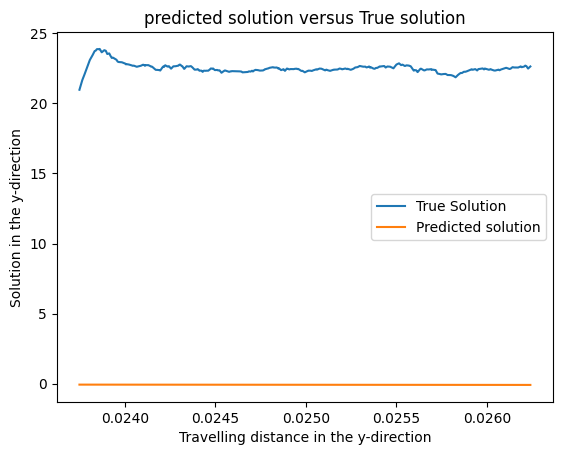

In [53]:
import matplotlib.pyplot as plt
plt.plot(x,usol.T[int(t.shape[0]/3)-1,:],label="True Solution")
plt.plot(x,u_pred.T[int(t.shape[0]/3)-1,:],label="Predicted solution")
plt.title(label="predicted solution versus True solution")
plt.title(label="predicted solution versus True solution")
plt.xlabel("Travelling distance in the y-direction")
plt.ylabel("Solution in the y-direction")
plt.legend()

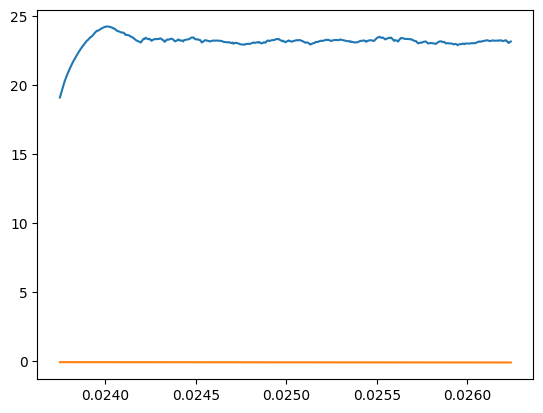

In [54]:
plt.plot(x,usol.T[int(t.shape[0]/3*2)-1,:])
plt.plot(x,u_pred.T[int(t.shape[0]/3*2)-1,:])

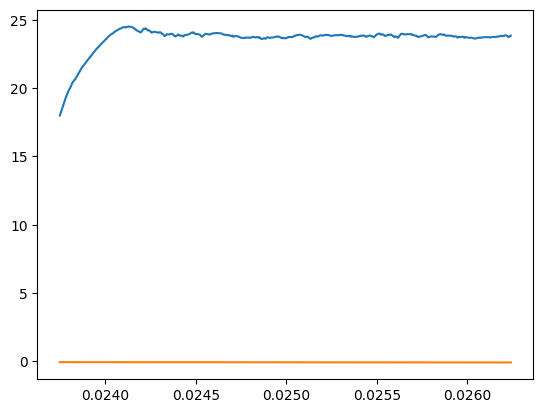

In [55]:
plt.plot(x,usol.T[int(t.shape[0])-1,:])
plt.plot(x,u_pred.T[int(t.shape[0])-1,:])

In [56]:
#plt.plot(x,usol)

In [57]:
#plt.plot(x,u_pred)

In [ ]:
#solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

### Plots

In [ ]:
# X_test[:,0]
# X_test[:,1]

In [ ]:
# arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
# arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
# arr_y1=u_pred
# arr_y_test=usol

In [ ]:
# u_pred
# x1
#t1

In [ ]:
# plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(arr_y1))

In [ ]:
# plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 